### agent_decision_analysis.ipynb
This notebook generates some data analysis using the `dd-mm-yyyy-principles.csv` file that is created from the notebook `generate_synthetic_principles_for_agents.ipynb`

This notebook requires you to have noted down the HCVA point and the transition point of your data. This is printed out in the terminal through running `solve.py` with the -pv flag (for principle value (HCVA)), and the -t flag

#### Compute decisions for each agent
This code imports the relevant files, and does a short sanity check to view the decisions of each agent

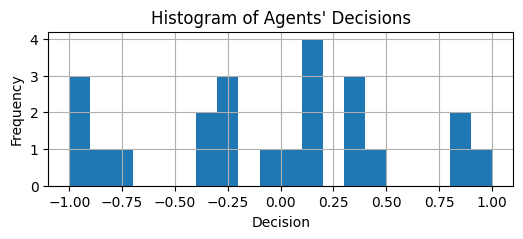

In [12]:
import pandas as pd
import numpy as np

agent_csv_file = "/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/processed_data_one_action_ess.csv_with_factor_2.5_5.0.csv"
agent_principle_file = "/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/results/02-01-2025-principles.csv"
agents_df = pd.read_csv(agent_csv_file)
agents_principle_df = pd.read_csv(agent_principle_file)

agents_df = pd.merge(agents_df, agents_principle_df, on='country')

# Compute decision for agent
for index, row in agents_df.iterrows():
    agents_df.at[index, 'decision'] = (agents_df.at[index, 'Rel-Nonrel'] * row['a_div_rel']) + (agents_df.at[index, 'Nonrel-Rel'] * row['a_div_nonrel'])
agents_df.rename(columns={'a_div_rel': 'Rel_div_p', 'a_div_nonrel': 'Nonrel_div_p'}, inplace=True)

# the processed_data_with_principles is the file that contains the principles for each country  
principle_filename = "/home/ia23938/Documents/GitHub/ValueSystemsAggregation/process_data/14-11-processed_data_with_principles_ess.csv"
pri_agents_df = pd.read_csv(principle_filename)
pri_agents_df.rename(columns={'rel': 'egal', 'nonrel' : 'util'}, inplace=True)
agents_df = pd.merge(agents_df, pri_agents_df)

# Now create Egal-Util and Util-Egal columns in the same format as Rel-Nonrel and Nonrel-Rel
for index, row in agents_df.iterrows():
    agents_df.at[index, 'Egal-Util'] = row['egal'] / (row['egal'] + row['util'])
    agents_df.at[index, 'Util-Egal'] = row['util'] / (row['egal'] + row['util'])

# A small sanity check
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 2))
agents_df['decision'].hist(bins=20)
plt.xlabel('Decision')
plt.ylabel('Frequency')
plt.title('Histogram of Agents\' Decisions')
plt.show()



#### Find the difference between each agent and each of the 4 different strategies (only on decision)

For every agent that has a value system that we have just generated, we now compare the agents decision against the different decisions found by each strategy.

In [13]:
################
# This code is taken directly from `generate_synthetic_principles_for_agents.ipynb`, as use is the same
# - Getting the relevant consensus values
################

#####
# 1.0 = Utilitarian, 1.4 = Transition point, 2.1 = HCVA, 10.0 = Egalitarian
###
relevent_consensuses =  [1.0, 1.4, 2.1, 10.0]
#relevent_consensuses = [round(x * 0.1, 1) for x in range(10, 101)]
relevant_columns = ['p','Rel-Nonrel', 'Nonrel-Rel', 'Rel_div_p', 'Nonrel_div_p', 'Egal-Util', 'Util-Egal']

actions_filename = "/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/results/02-01-2025-actions-a-2.5-p-5.0.csv"
preference_filename = '/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/results/02-01-2025-preferences-a-2.5-p-5.0.csv'

final_df_savename = "/home/ia23938/Documents/GitHub/ValueSystemsAggregation/data/ess_example_data/02-01-2025-ess-relevant-consensus.csv"

pref_df = pd.read_csv(preference_filename)
act_df = pd.read_csv(actions_filename)
cons_df = pd.merge(pref_df, act_df, on='p')
cons_df['p'] = cons_df['p'].round(1)
# for each row, find the corresponding Util-Egal and Egal-Util values (where P=1.0 has Util-Egal=1.0 and Egal-Util=0.0, and P=10.0 has Util-Egal=0.0 and Egal-Util=1.0)
for index, row in cons_df.iterrows():
    cons_df.at[index, 'Egal-Util'] = (row['p'] - 1) / 9
    cons_df.at[index, 'Util-Egal'] = 1 - cons_df.at[index, 'Egal-Util']

# As of 14/11, using processed_data_one_action_with_factor_2.5_5.0 P values 1.0-1.7 are for the scheme, 1.8 - 10.0 are against
against_scheme = list(np.arange(1.8, 10.0, 0.1))
for_scheme = list(np.arange(1.0, 1.7, 0.1))
against_scheme = [round(num, 1) for num in against_scheme]
for_scheme = [round(num, 1) for num in for_scheme]

final_df = pd.DataFrame()
for consensus in relevent_consensuses:
    filtered_df = cons_df[cons_df['p'] == consensus][relevant_columns]
    filtered_df['decision'] = (filtered_df['Rel_div_p'] * filtered_df['Rel-Nonrel']) + (filtered_df['Nonrel_div_p'] * filtered_df['Nonrel-Rel'])
    final_df = pd.concat([final_df, filtered_df], ignore_index=True)
final_df.to_csv(final_df_savename)
final_df

,p,Rel-Nonrel,Nonrel-Rel,Rel_div_p,Nonrel_div_p,Egal-Util,Util-Egal,decision
0,1.0,0.346411,0.653589,0.010277,0.144976,0.000000,1.000000,0.098315
1,1.4,0.345776,0.654224,-0.089210,0.077451,0.044444,0.955556,0.019824
2,2.1,0.352679,0.647321,-0.113565,0.042727,0.122222,0.877778,-0.012394
3,10.0,0.371893,0.628107,-0.042340,0.007190,1.000000,0.000000,-0.011230


In [14]:
strategy_df = final_df
agents_df['min_distance'] = agents_df.apply(
    lambda row: min(abs(row['decision'] - strategy_decision) for strategy_decision in strategy_df['decision']),
    axis=1
)
agents_df['closest_p'] = agents_df.apply(
    lambda row: strategy_df.loc[(strategy_df['decision'] - row['decision']).abs().idxmin(), 'p'],
    axis=1
)
agents_df
print(agents_df['closest_p'].value_counts())

closest_p
1.0    12
2.1    11
Name: count, dtype: int64


### Value System Comparison
Instead of looking at decisions, instead look at the distance from the consensus value system to the agents individual value systems 

In [15]:
# Comparing using these values: Rel-Nonrel	Nonrel-Rel	Rel_div_p	Nonrel_div_p
# Function to calculate Euclidean distance
def euclidean_distance(row1, row2, compare_columns):
    return np.sqrt(sum((row1[col] - row2[col]) ** 2 for col in compare_columns))

def chebyshev_distance(row1, row2, compare_columns):
    return max(abs(row1[col] - row2[col]) for col in compare_columns)

def manhattan_distance(row1, row2, compare_columns):
    return sum(abs(row1[col] - row2[col]) for col in compare_columns)
distance_measures = {
    'euclidean': euclidean_distance,
    'chebyshev': chebyshev_distance,
    'manhattan': manhattan_distance
}

### Distance Measures Results
Firstly, we compare against only using the personal value system of each agent
Secondly, we compare against using both the personal value systems and the principle value system for each agent

In [18]:
from tabulate import tabulate

# Define the columns to compare
compare_columns = ['Rel-Nonrel', 'Nonrel-Rel', 'Rel_div_p', 'Nonrel_div_p']

for measure in distance_measures:
    agents_df[f'closest_p_{measure}'] = agents_df.apply(
        lambda agent_row: strategy_df.loc[
            strategy_df.apply(lambda final_row: distance_measures[measure](agent_row, final_row, compare_columns), axis=1).idxmin()
        ]['p'],
        axis=1
    )

    print(f"closest set according to {measure} distance: ", agents_df[f'closest_p_{measure}'].value_counts())


# Define the strategies and their corresponding p values
strategies = {
    'Utilitarian (1.0)': 1.0,
    'Transition (1.4)': 1.4,
    'HCVA (2.1)': 2.1,
    'Egalitarian (10.0)': 10.0
}

# Create a list to store the table rows
table_rows = []

# Iterate over the strategies and count the number of agents aligned to each strategy for each distance measure
for strategy, p_value in strategies.items():
    row = [strategy]
    row.append(final_df[final_df['p'] == p_value]['decision'].values[0])
    for measure in distance_measures:
        count = agents_df[agents_df[f'closest_p_{measure}'] == p_value].shape[0]
        row.append(count)
    table_rows.append(row)

# Print the table in LaTeX format
latex_table = tabulate(table_rows, headers=['Strategy', 'Decision', 'Agents Aligned (Euclidean)', 'Agents Aligned (Chebyshev)', 'Agents Aligned (Manhattan)'], tablefmt='latex')
print(latex_table)

closest set according to euclidean distance:  closest_p_euclidean
1.0     10
2.1      8
10.0     5
Name: count, dtype: int64
closest set according to chebyshev distance:  closest_p_chebyshev
10.0    11
1.0      8
2.1      4
Name: count, dtype: int64
closest set according to manhattan distance:  closest_p_manhattan
1.0     11
10.0    11
2.1      1
Name: count, dtype: int64
\begin{tabular}{lrrrr}
\hline
 Strategy           &   Decision &   Agents Aligned (Euclidean) &   Agents Aligned (Chebyshev) &   Agents Aligned (Manhattan) \\
\hline
 Utilitarian (1.0)  &  0.098315  &                           10 &                            8 &                           11 \\
 Transition (1.4)   &  0.0198238 &                            0 &                            0 &                            0 \\
 HCVA (2.1)         & -0.0123937 &                            8 &                            4 &                            1 \\
 Egalitarian (10.0) & -0.0112298 &                            5 &       

In [ ]:
# Comparing using these values: Rel-Nonrel	Nonrel-Rel	Rel_div_p	Nonrel_div_p

# Define the columns to compare
compare_columns = ['Rel-Nonrel', 'Nonrel-Rel', 'Rel_div_p', 'Nonrel_div_p', 'Egal-Util', 'Util-Egal']
# Caclulate the principles for the consensus values

for measure in distance_measures:
    agents_df[f'closest_p_{measure}'] = agents_df.apply(
        lambda agent_row: strategy_df.loc[
            strategy_df.apply(lambda final_row: distance_measures[measure](agent_row, final_row, compare_columns), axis=1).idxmin()
        ]['p'],
        axis=1
    )
    print(f"closest set according to {measure} distance: ", agents_df[f'closest_p_{measure}'].value_counts())

# Define the strategies and their corresponding p values
strategies = {
    'Utilitarian (1.0)': 1.0,
    'Transition (1.4)': 1.4,
    'HCVA (2.1)': 2.1,
    'Egalitarian (10.0)': 10.0
}

# Create a list to store the table rows
table_rows = []

# Iterate over the strategies and count the number of agents aligned to each strategy for each distance measure
for strategy, p_value in strategies.items():
    row = [strategy]
    row.append(final_df[final_df['p'] == p_value]['decision'].values[0])
    for measure in distance_measures:
        count = agents_df[agents_df[f'closest_p_{measure}'] == p_value].shape[0]
        row.append(count)
    table_rows.append(row)

# Print the table in LaTeX format
latex_table = tabulate(table_rows, headers=['Strategy', 'Decision', 'Agents Aligned (Euclidean)', 'Agents Aligned (Chebyshev)', 'Agents Aligned (Manhattan)'], tablefmt='latex')
print(latex_table)



closest set according to euclidean distance:  closest_p_euclidean
1.0     10
10.0     7
2.1      6
Name: count, dtype: int64
closest set according to chebyshev distance:  closest_p_chebyshev
2.1     9
1.0     8
10.0    6
Name: count, dtype: int64
closest set according to manhattan distance:  closest_p_manhattan
2.1     11
10.0     7
1.0      5
Name: count, dtype: int64
\begin{tabular}{lrrrr}
\hline
 Strategy           &   Decision &   Agents Aligned (Euclidean) &   Agents Aligned (Chebyshev) &   Agents Aligned (Manhattan) \\
\hline
 Utilitarian (1.0)  &  0.098315  &                           10 &                            8 &                            5 \\
 Transition (1.4)   &  0.0198238 &                            0 &                            0 &                            0 \\
 HCVA (2.1)         & -0.0123937 &                            6 &                            9 &                           11 \\
 Egalitarian (10.0) & -0.0112298 &                            7 &          